In [1]:
import matplotlib.pyplot as plt 
import json
import pickle
import torch
import random 
import numpy as np
import os 

from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import binary_cross_entropy
from sklearn import metrics 

from data_loaders.assist2009 import ASSIST2009
from data_loaders.assist2012 import ASSIST2012
from data_loaders.ednet01 import EdNet01

from models.dkvmn_text import SUBJ_DKVMN
from models.dkvmn_text import train_model as plus_train

from models.utils import collate_fn, collate_ednet, cal_acc_class

%matplotlib inline

seed = 1004

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

c:\Users\user2\Desktop\master_degree\research\env_research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'dkvmn+'
dataset_name = 'ASSIST2009'
dataset = None
ckpts = f"ckpts/{model_name}/{dataset_name}/"

with open("config.json") as f:
    config = json.load(f)
    model_config = config[model_name]
    train_config = config["train_config"]
    
batch_size = train_config["batch_size"]
num_epochs = train_config["num_epochs"]
train_ratio = train_config["train_ratio"]
learning_rate = train_config["learning_rate"]
optimizer = train_config["optimizer"] # can be sgd, adam
seq_len = train_config["seq_len"] # 샘플링 할 갯수

In [3]:
# 데이터셋 추가 가능
collate_pt = collate_fn
if dataset_name == "ASSIST2009":
    dataset = ASSIST2009(seq_len, 'datasets/ASSIST2009/')
elif dataset_name == "ASSIST2012":
    dataset = ASSIST2012(seq_len, 'datasets/ASSIST2012/')

In [4]:
def train_model(model, test_loader, ckpt_path):
    '''
        Args:
            train_loader: the PyTorch DataLoader instance for training
            test_loader: the PyTorch DataLoader instance for test
            num_epochs: the number of epochs
            opt: the optimization to train this model
            ckpt_path: the path to save this model's parameters
    '''
    aucs = []
    loss_means = []  
    accs = []
    q_accs = {}
    
    max_auc = 0
    
    # Test
    model.load_state_dict(torch.load(os.path.join(ckpt_path, "model.ckpt"), map_location=device))
    loss_mean = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            q, r, qshft_seqs, rshft_seqs, m, bert_s, bert_t, bert_m, q2diff_seqs, pid_seqs, pidshift, hint_seqs = data

            model.eval()

            y, Mv, w = model(q.long(), r.long(), bert_s, bert_t, bert_m, q2diff_seqs.long(), pid_seqs.long())

            # y와 t 변수에 있는 행렬들에서 마스킹이 true로 된 값들만 불러옴
            q = torch.masked_select(q, m).detach().cpu()
            y = torch.masked_select(y, m).detach().cpu()
            t = torch.masked_select(r, m).detach().cpu()

            auc = metrics.roc_auc_score(
                y_true=t.numpy(), y_score=y.numpy()
            )
            bin_y = [1 if p >= 0.5 else 0 for p in y.numpy()]
            acc = metrics.accuracy_score(t.numpy(), bin_y)
            loss = binary_cross_entropy(y, t) # 실제 y^T와 원핫 결합, 다음 answer 간 cross entropy

            print(f"[Test] number: {i}, AUC: {auc}, ACC: :{acc} Loss: {loss} ")

            # evaluation metrics
            aucs.append(auc)
            loss_mean.append(loss)     
            accs.append(acc)
            q_accs, cnt = cal_acc_class(q.long(), t.long(), bin_y)
            break
        loss_means.append(np.mean(loss_mean))


    return aucs, loss_means, accs, q_accs, cnt, Mv, w, q, t

In [5]:
model = SUBJ_DKVMN(dataset.num_q, num_qid=dataset.num_pid, **model_config)
train_model = train_model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# 데이터셋 분할
data_size = len(dataset)
train_size = int(data_size * train_ratio) 
valid_size = int(data_size * ((1.0 - train_ratio) / 2.0))
test_size = data_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size], generator=torch.Generator(device=device)
)

# pickle에 얼마만큼 분할했는지 읽기
if os.path.exists(os.path.join(dataset.dataset_dir, "train_indices.pkl")):
    with open(
        os.path.join(dataset.dataset_dir, "train_indices.pkl"), "rb"
    ) as f:
        train_dataset.indices = pickle.load(f)
    with open(
        os.path.join(dataset.dataset_dir, "valid_indicies.pkl"), "rb"
    ) as f:
        valid_dataset.indices = pickle.load(f)
    with open(
        os.path.join(dataset.dataset_dir, "test_indices.pkl"), "rb"
    ) as f:
        test_dataset.indices = pickle.load(f)

In [7]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_pt, generator=torch.Generator(device=device)
)
valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_pt, generator=torch.Generator(device=device)
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_pt, generator=torch.Generator(device=device)
)

if optimizer == "sgd":
    opt = SGD(model.parameters(), learning_rate, momentum=0.9)
elif optimizer == "adam":
    opt = Adam(model.parameters(), learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)
opt.lr_scheduler = lr_scheduler

model = SUBJ_DKVMN(dataset.num_q, num_qid=dataset.num_pid, **model_config)

# 모델에서 미리 정의한 함수로 AUCS와 LOSS 계산    
aucs, loss_means, accs, q_accs, q_cnts, Mv, w, q, t = \
    train_model(
        model, test_loader, ckpts
    )

[Test] number: 0, AUC: 0.9681324808848354, ACC: :0.9289991445680068 Loss: 0.18885724246501923 


In [8]:
print(torch.max(Mv[:, :-1])) # 컨셉 수 / 시퀀스? 임베딩 수

tensor(7.8469)


In [9]:
print(q, t)

tensor([  0.,   0.,   0.,  ..., 100., 100.,  69.]) tensor([0., 0., 1.,  ..., 0., 0., 1.])


In [10]:
print(q[q==102])

tensor([102.])


In [21]:
# 모든 W값에 대한 빈 텐서를 생성
# 마지막 layer 빼서 넘겨보기

# Read Process = w * M
# 그래서 R 값은 마스크한 형태이고, W값은 마스킹 한 쪽에 0값 달라는 얘기인 것 같음
# 그럼 결론적으로 메모리만 들어가면 됨
# input embedding 의 weight값에 마스킹 -> 문제 정보 이그노어
# 1. R => memory로 그대로 사용
# 2. Input Embedding (key embedding) 값 마스킹
# 3. Linear 레이어에 통과 => 이게 concept state가 될거라고 함..
# Memory 

knowledge_state = []
# 1. 기존식의 Read content => memory value로 그대로 사용
r = Mv[:, :-1]
print(r.shape)

# 2. 컨셉별 Key Embedding 값 마스킹
rm = torch.zeros_like(r)

print(r.shape, rm.shape,)

# 3. Linear 레이어에 통과
f = torch.tanh(
    model.f_layer(
    torch.cat(
        [
            r, # 하나 생성했으므로 마지막이 아닌 마지막 전의 110개의 컨셉들을 다 더해줌.
            rm
        ],
        dim=-1
    )
    )
)

# 그 후 예측값 뱉기
p = model.p_layer(model.dropout_layer(f))

p = torch.sigmoid(p)
p = p.squeeze(-1)
print(p.shape)
print(p)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([24, 100, 110, 100])
torch.Size([24, 100, 110, 100]) torch.Size([24, 100, 110, 100])
torch.Size([24, 100, 110])
tensor([[[0.5168, 0.5150, 0.5190,  ..., 0.5094, 0.5077, 0.5180],
         [0.5193, 0.5319, 0.5177,  ..., 0.5134, 0.5194, 0.5109],
         [0.5232, 0.5267, 0.5186,  ..., 0.5141, 0.5200, 0.5146],
         ...,
         [0.5246, 0.5202, 0.5210,  ..., 0.5055, 0.5138, 0.5213],
         [0.5200, 0.5172, 0.5113,  ..., 0.5192, 0.5112, 0.5195],
         [0.5271, 0.5271, 0.5130,  ..., 0.5147, 0.5182, 0.5107]],

        [[0.5259, 0.5176, 0.5166,  ..., 0.5083, 0.5209, 0.5216],
         [0.5321, 0.5197, 0.5131,  ..., 0.5129, 0.5055, 0.5160],
         [0.5287, 0.5149, 0.5132,  ..., 0.5107, 0.5138, 0.5173],
         ...,
         [0.5295, 0.5264, 0.5138,  ..., 0.5148, 0.5093, 0.5089],
         [0.5206, 0.5220, 0.5139,  ..., 0.5163, 0.5144, 0.5107],
         [0.5142, 0.5161, 0.5164,  ..., 0.5087, 0.5086, 0.5165]],

        [[0.5161, 0.5219, 0.5165,  ..., 0.5097, 0.5120, 0.5236],


In [60]:
import seaborn as sns # 히트맵 사용
# import matplotlib.
import matplotlib.pyplot as plt

cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

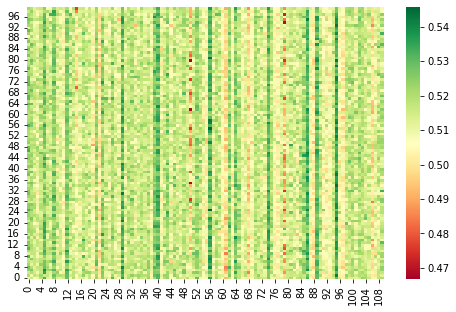

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = sns.heatmap(p[23].detach().cpu().numpy(), cmap=plt.get_cmap('RdYlGn'))
ax.invert_yaxis()
plt.show()